# 03 Segmentation / Clustering (Region-Level)

We cluster **regions** based on demand and price behavior to identify strategic segments.

**Features per region (examples):**
- Mean/Median ASP
- Mean Total Volume
- Volume Volatility (std)
- ASP Volatility (std)
- YoY Volume Growth (approx.)
- Seasonality Strength (monthly volume index variance)

**Models:** Standardization → (optional) PCA → **KMeans** (with elbow and silhouette guidance)



In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

DATA_PATH = os.path.join('..', 'data', 'avocado.csv')
df = pd.read_csv(DATA_PATH)
df.columns = [c.strip().replace(' ', '_').lower() for c in df.columns]
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Aggregate region-level features
region_stats = df.groupby('region').agg(
    mean_asp=('averageprice','mean'),
    median_asp=('averageprice','median'),
    mean_volume=('total_volume','mean'),
    std_volume=('total_volume','std'),
    std_asp=('averageprice','std')
).fillna(0)

# Approximate YoY growth in volume
yoy = (df.groupby(['region','year'])['total_volume'].sum()
         .groupby(level=0).pct_change()
         .rename('yoy_volume_growth').reset_index())
yoy_latest = yoy.sort_values(['region','year']).groupby('region').tail(1).set_index('region')['yoy_volume_growth']
region_stats['yoy_volume_growth'] = yoy_latest.reindex(region_stats.index).fillna(0)

# Seasonality strength (variance of monthly seasonality index)
monthly = df.groupby(['region','month'])['total_volume'].mean().reset_index()
avg_region = monthly.groupby('region')['total_volume'].mean().rename('avg_region')
monthly = monthly.merge(avg_region, on='region', how='left')
monthly['seasonality_index'] = monthly['total_volume'] / monthly['avg_region']
seasonality_strength = monthly.groupby('region')['seasonality_index'].var().rename('seasonality_strength')
region_stats = region_stats.join(seasonality_strength, how='left').fillna(0)

print(region_stats.head())


                     mean_asp  median_asp    mean_volume     std_volume  \
region                                                                    
Albany               1.561036       1.560   47537.869734   49848.851329   
Atlanta              1.337959       1.230  262145.322041  263107.066787   
BaltimoreWashington  1.534231       1.550  398561.891479  387253.741496   
Boise                1.348136       1.220   42642.567308   42479.404396   
Boston               1.530888       1.555  287792.854527  284412.868048   

                      std_asp  yoy_volume_growth  seasonality_strength  
region                                                                  
Albany               0.291986          -0.705254              0.016512  
Atlanta              0.398297          -0.714337              0.015277  
BaltimoreWashington  0.299428          -0.703554              0.010980  
Boise                0.457911          -0.744829              0.019343  
Boston               0.328074       

## Standardize, Optional PCA, and KMeans


Explained variance by 2 PCs: 0.6250868445540921


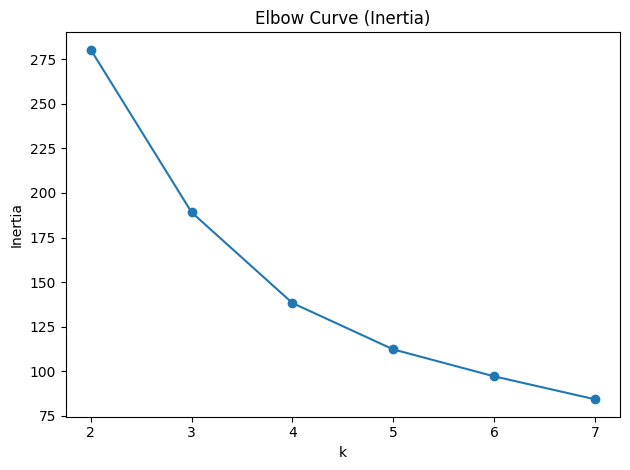

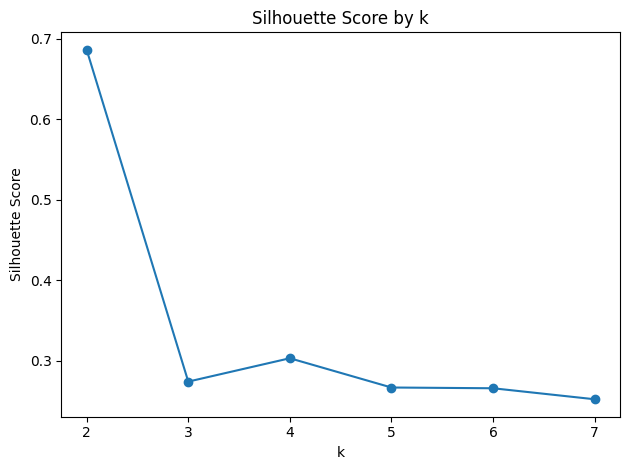

Chosen k: 2
                region  mean_asp  median_asp    mean_volume     std_volume  \
0               Albany  1.561036       1.560   47537.869734   49848.851329   
1              Atlanta  1.337959       1.230  262145.322041  263107.066787   
2  BaltimoreWashington  1.534231       1.550  398561.891479  387253.741496   
3                Boise  1.348136       1.220   42642.567308   42479.404396   
4               Boston  1.530888       1.555  287792.854527  284412.868048   

    std_asp  yoy_volume_growth  seasonality_strength  cluster  
0  0.291986          -0.705254              0.016512        0  
1  0.398297          -0.714337              0.015277        0  
2  0.299428          -0.703554              0.010980        0  
3  0.457911          -0.744829              0.019343        0  
4  0.328074          -0.717843              0.008654        0  


In [5]:

features = region_stats.copy()
scaler = StandardScaler()
X = scaler.fit_transform(features)

# Optional PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print('Explained variance by 2 PCs:', pca.explained_variance_ratio_.sum())

# Elbow & silhouette to guide k
inertias = []
sil_scores = []
K = range(2, 8)
for k in K:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    #inertias.append(km.inertia())
    sil_scores.append(silhouette_score(X, labels))

plt.figure()
plt.plot(list(K), inertias, marker='o')
plt.title('Elbow Curve (Inertia)')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(list(K), sil_scores, marker='o')
plt.title('Silhouette Score by k')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

# Choose k (example: best silhouette)
best_k = K[np.argmax(sil_scores)]
kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=42)
labels = kmeans.fit_predict(X)

segments = features.copy()
segments['cluster'] = labels
segments.reset_index(inplace=True)
segments.rename(columns={'index':'region'}, inplace=True)

print('Chosen k:', best_k)
print(segments.head())


## Segment Narratives

Interpret each cluster in terms of business actions (pricing, supply, marketing).


         mean_asp   mean_volume    std_volume  std_asp  yoy_volume_growth  \
cluster                                                                     
0        1.407595  5.392406e+05  5.335328e+05  0.35994          -0.717564   
1        1.319024  1.735130e+07  1.696847e+07  0.29546          -0.719186   

         seasonality_strength  
cluster                        
0                    0.018472  
1                    0.016765  


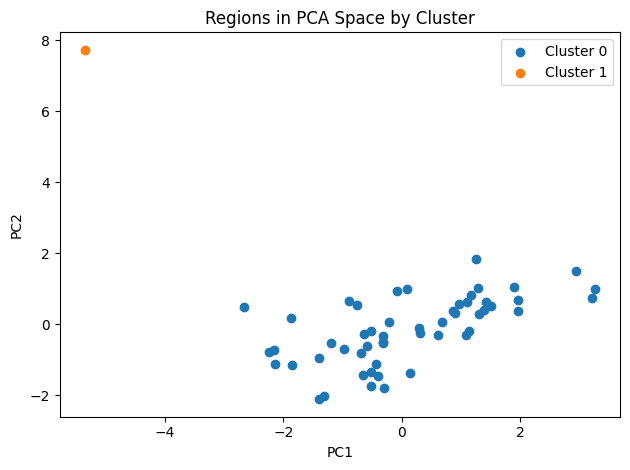

In [6]:

cluster_profiles = segments.groupby('cluster').agg(
    mean_asp=('mean_asp','mean'),
    mean_volume=('mean_volume','mean'),
    std_volume=('std_volume','mean'),
    std_asp=('std_asp','mean'),
    yoy_volume_growth=('yoy_volume_growth','mean'),
    seasonality_strength=('seasonality_strength','mean')
)

print(cluster_profiles)

plt.figure()
for c in sorted(segments['cluster'].unique()):
    mask = segments['cluster'] == c
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=f'Cluster {c}')
plt.title('Regions in PCA Space by Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.tight_layout()
plt.show()
